In [78]:
from os.path import abspath
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import inspect

In [79]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [80]:
# create database
# File location and type
file_location_array = [
    {"location" : "../../training/pred_tremi_v2.csv", "name": "pred_tremi_full", "delimiter": ","},
    {"location" : "../../training/pred_tremi_full.csv", "name": "pred_tremi_fullv1", "delimiter": ","},
    {"location" :  "../../training/dpe_full.csv", "name": "dpe", "delimiter": ","},
    {"location" :  "../../training/prediction_dpe.csv", "name": "prediction_dpe", "delimiter": ","},
    {"location" :  "../../training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type) \
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )
    dataframes[file["name"]].show()

+------+---+----------+----------+---------------+------+----+-----------------+--------------+----------+---------------------+----------------------+---------------+---------------------+-----------------+-------+------------------+----------------+
|gender|age|occupation|home_state|nb_persons_home|income|type|construction_date|heating_system|population|n_development_licence|n_construction_licence|n_new_buildings|n_destruction_licence|department_number|surface|heating_production|heating_emission|
+------+---+----------+----------+---------------+------+----+-----------------+--------------+----------+---------------------+----------------------+---------------+---------------------+-----------------+-------+------------------+----------------+
|     0| 39|        13|         0|              3|     4|   0|                3|             0|     12368|                    4|                    41|             43|                    0|               50|   null|              null|          

In [81]:
training_tremi = (
    dataframes['pred_tremi_full'].withColumns({
        'surface' : F.col('surface').cast('float'),
        'heating_production' : F.col('heating_production').cast('int'),
        'heating_emission' : F.col('heating_emission').cast('int')
    })
)

dictionary = dataframes['dictionary']

In [82]:

training_surf = training_tremi.filter(F.col('surface').isNotNull()).drop('heating_emission', 'heating_production')
predicting_surf = training_tremi.filter(F.col('surface').isNull()).drop('heating_emission', 'heating_production')

training_prod = training_tremi.filter(F.col('heating_production').isNotNull()).drop('heating_emission', 'surface')
predicting_prod = training_tremi.filter(F.col('heating_production').isNull()).drop('heating_emission', 'surface')

training_em = training_tremi.filter(F.col('heating_emission').isNotNull()).drop('surface', 'heating_production')
predicting_em = training_tremi.filter(F.col('heating_emission').isNull()).drop('surface', 'heating_production')

training_surf2 = (
    dataframes['pred_tremi_fullv1'].withColumns({
        'surface' : F.col('surface').cast('float'),
        'heating_production' : F.col('heating_production').cast('int'),
        'heating_emission' : F.col('heating_emission').cast('int')
    })
    .filter(F.col('surface').isNotNull()).drop('heating_emission', 'heating_production')
)

print(training_surf.count(), predicting_surf.count(), training_prod.count(), predicting_prod.count(), training_em.count(), predicting_em.count())

12565 26933 11128 28370 12558 26940


In [83]:
# get the name of  variable outside fonction
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

# cut variable name if too long
def cut(name):
    if isinstance(name, str) and len(name)>25:
        return name[0:25]
    return name

# get all values in dict form
def get_dict(df):
    col_names = [col[0] for col in df.dtypes]
    values = {}
    rows = df.collect()
    for col_name in col_names:
        values[col_name] = [cut(row[col_name]) for row in rows]
    return values

# get labels for a variable thanks to dictionary
def get_labels(variable):
    study = (
        dictionary.filter(
            (F.col('column') == variable) &
            (~F.col('value').contains('-'))
        )
        .select(
            F.col('value'),
            F.col('meaning')
        )
        .dropDuplicates()
        .orderBy(F.col('value').cast('int'))
    )
    return get_dict(study)

# return ticks for pie
def get_percent(value, values):
    total = sum(values)
    if len(values) < 5:
        return f'{value/100*total:.0f}\n{value:.2f}%'
    else:
        return f'{value:.1f}'

# plot pie
def plot_repartition(df, variable, ax, title=None):
    labels = get_labels(variable)['meaning']
    count = get_dict(df.withColumn(variable, F.col(variable).cast(int)).groupBy(variable).count().orderBy(variable))['count']
    ax.pie(count, labels = labels, autopct=lambda x: get_percent(x,count),startangle=90)
    if title:
        ax.set_title(title)

# plot_hist
def plot_hist(df, variable, ax, title=None):
    
    labels = get_labels(variable)['meaning']
    values = get_dict(df.groupBy(variable).count().orderBy(variable))
    total = sum(values['count'])
    percent = [value * 100 / total for value in values['count']]
    x = values[variable]
    min_value = int(min(values[variable]))

    # bar graph
    bars = ax.bar(x=x, height = percent, width=0.5)
    ax.set_xticks(range(min_value, len(labels) + min_value), labels, rotation = 90)

    # set y ticks
    vals = ax.get_yticks()
    ax.set_yticklabels(['%1.2f%%' %i for i in vals])

    # plot percentage
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.1f}%",(bar.get_x() + bar.get_width()/2, height+.05),ha="center",va="bottom",fontsize=10)

    # title
    if title:
        ax.set_title(title)

# plot multiple chart
def compare_repartition(dfs, variable):
    f, ax = plt.subplots(1, len(dfs), figsize=(20,5), sharey=True)
    plt.subplots_adjust(wspace=0.2)
    plt.suptitle(variable)
    if len(dfs) > 1:
        for i, df in enumerate(dfs):
            plot_hist(df, variable, ax[i], retrieve_name(df))
    else:
        plot_hist(dfs[0], variable, ax, retrieve_name(dfs[0]))

# input variables

C:\Users\arocheteau\AppData\Local\Temp\ipykernel_3744\2412955291.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%1.2f%%' %i for i in vals])


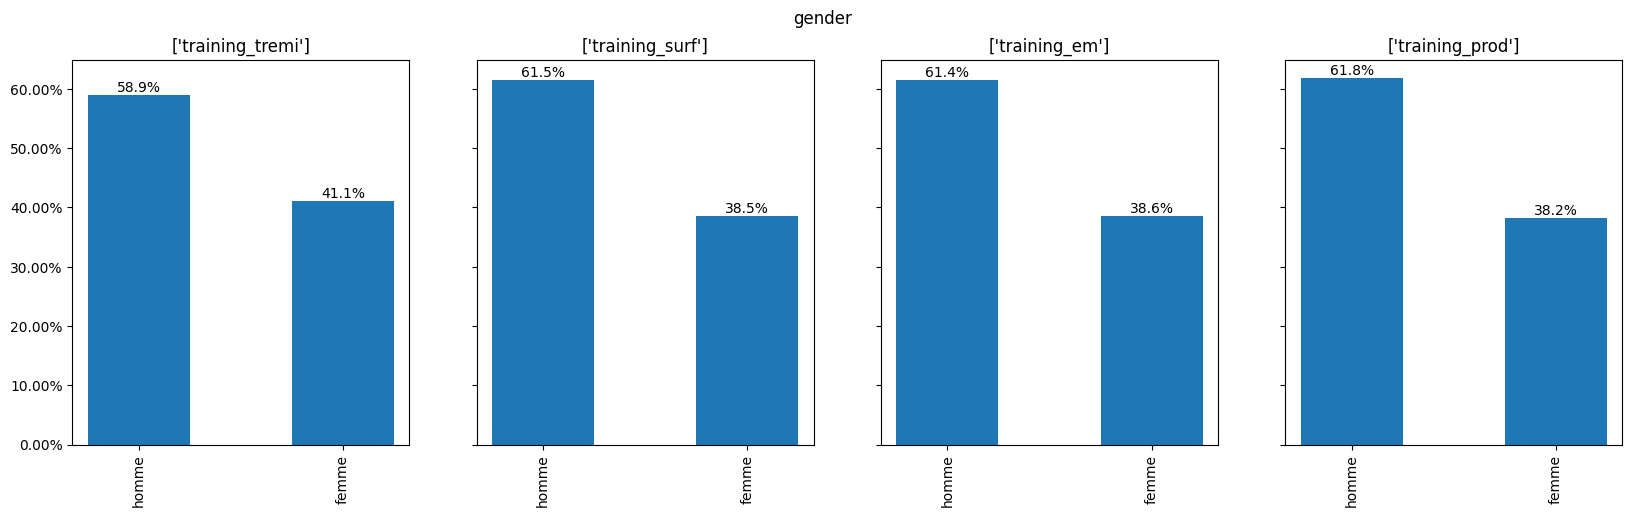

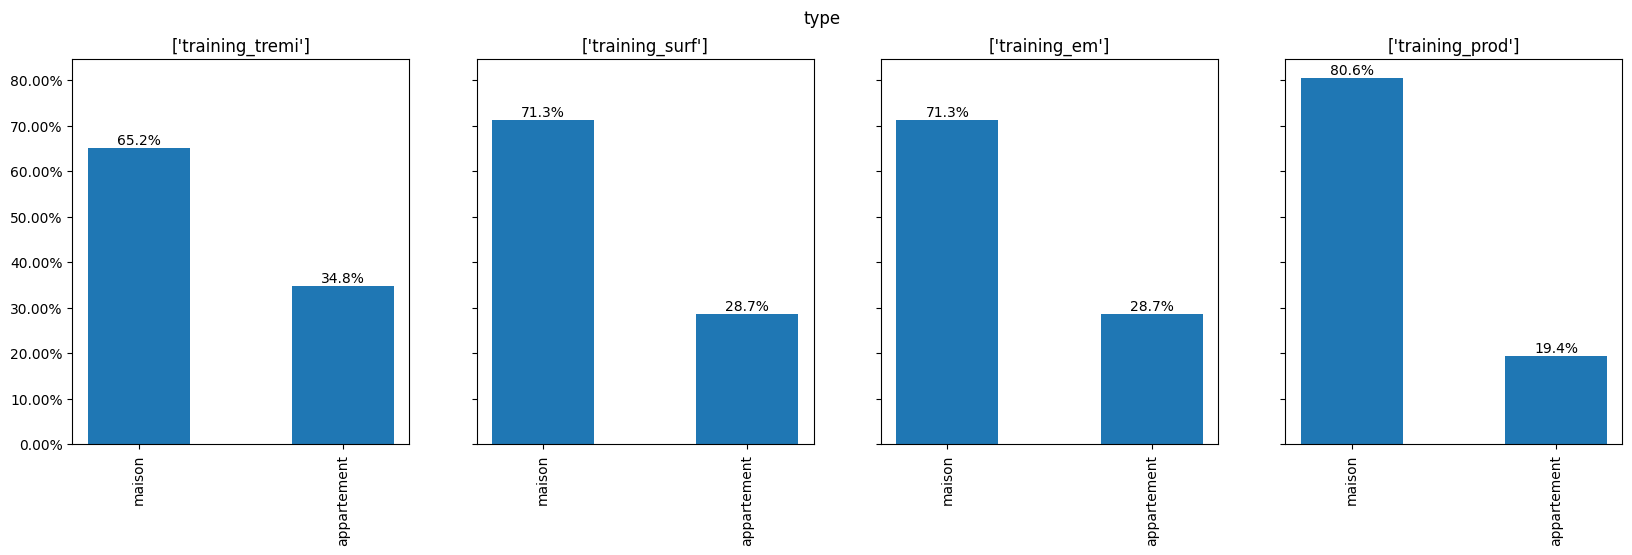

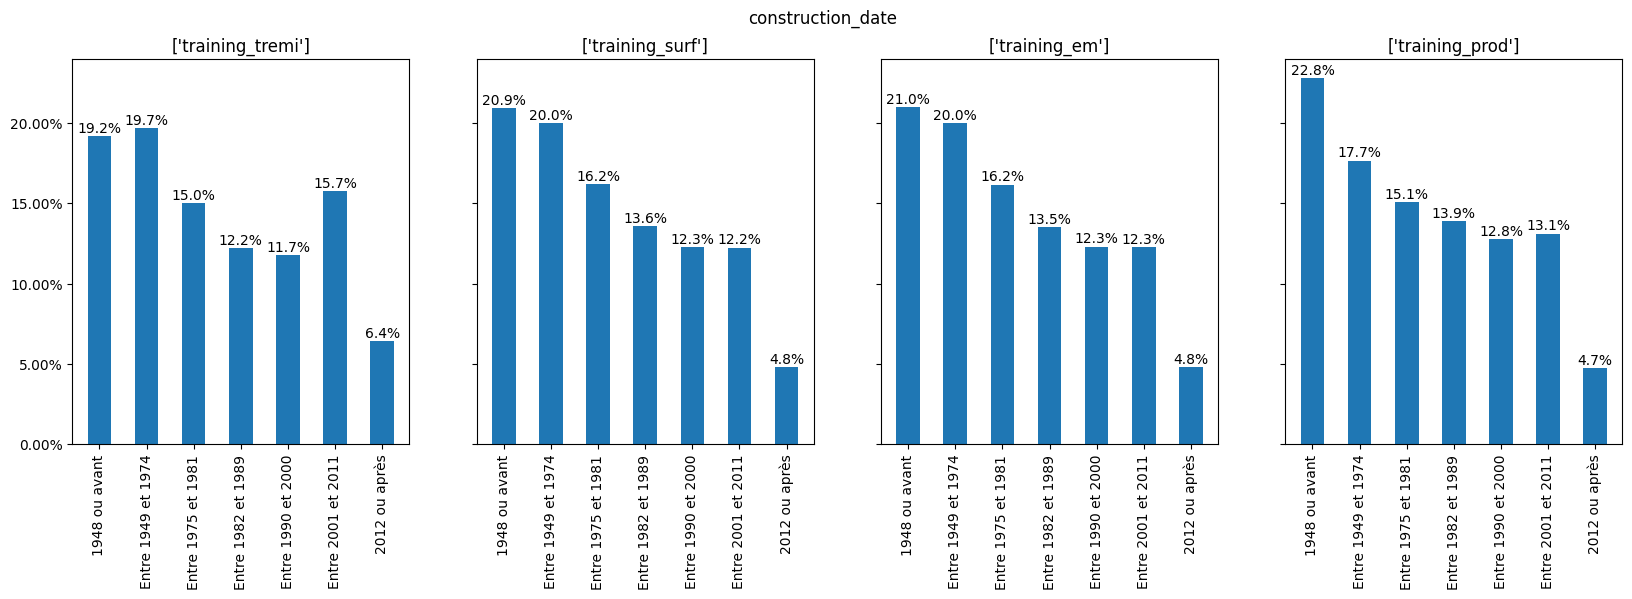

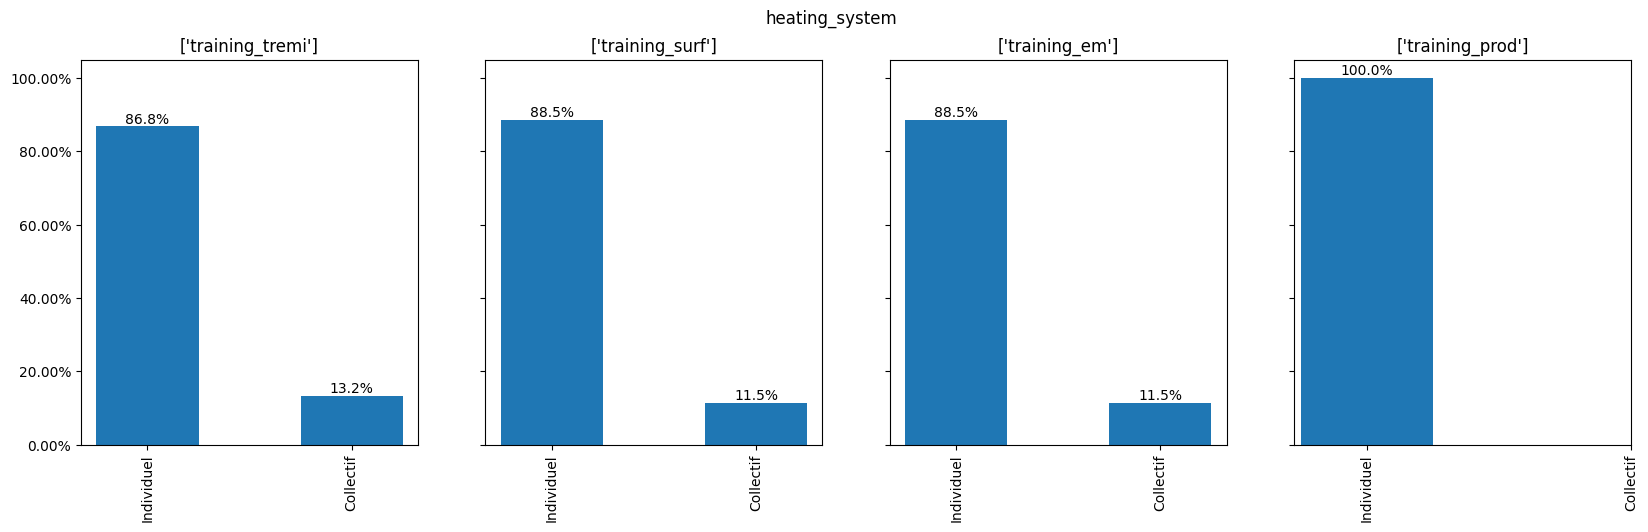

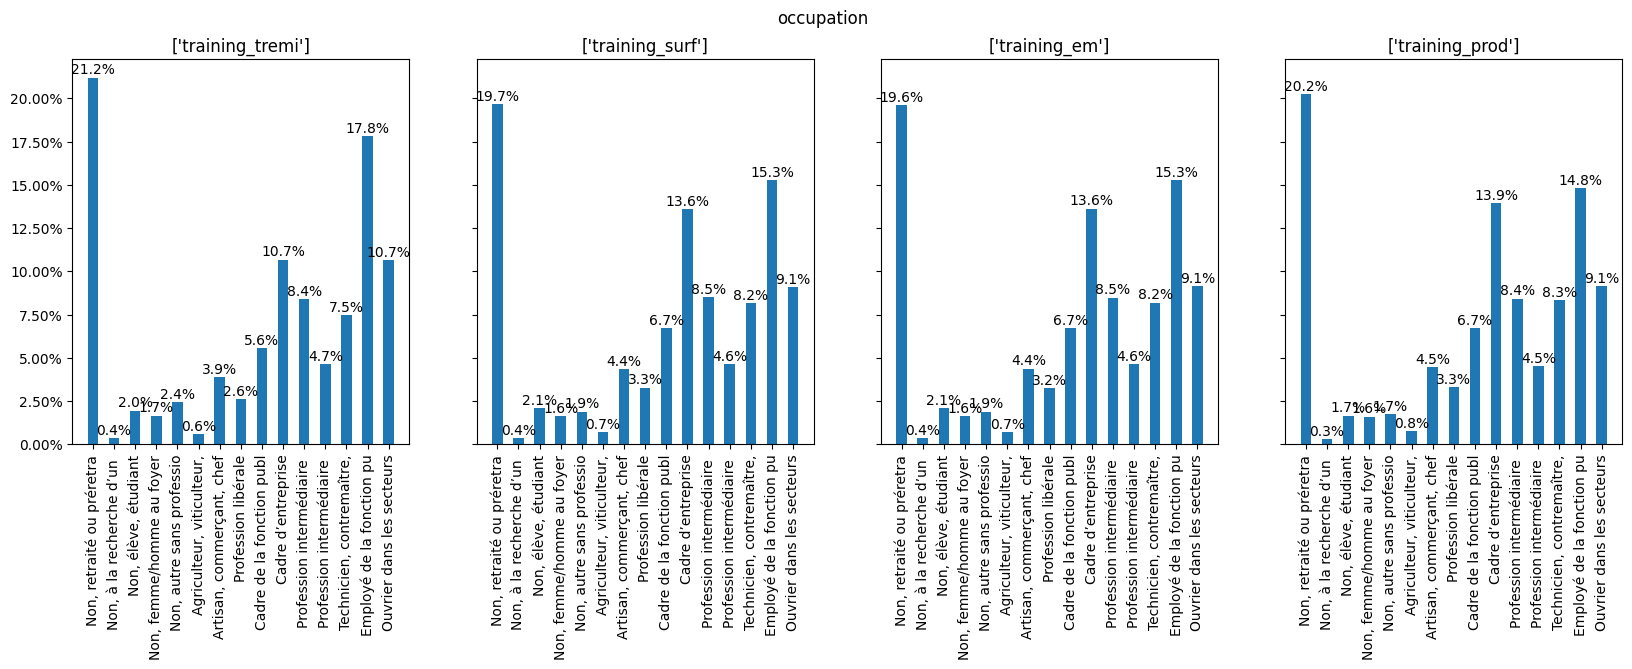

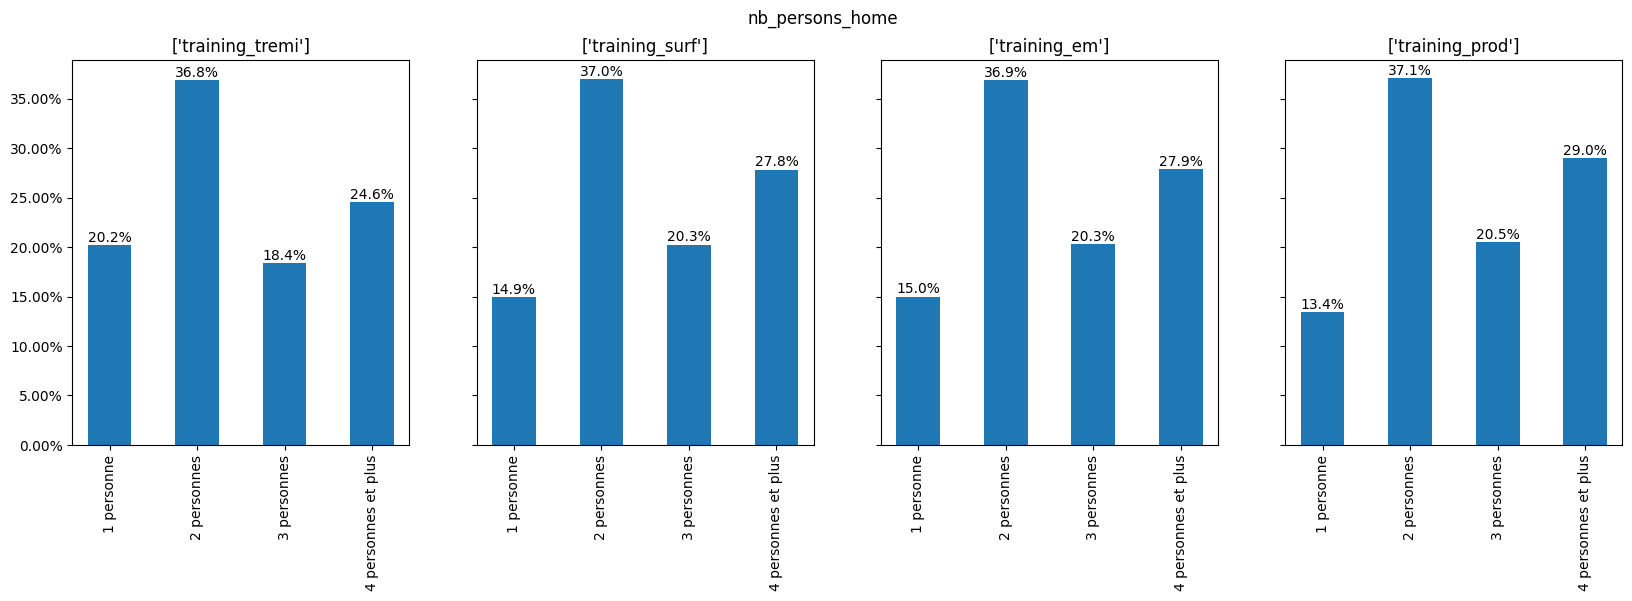

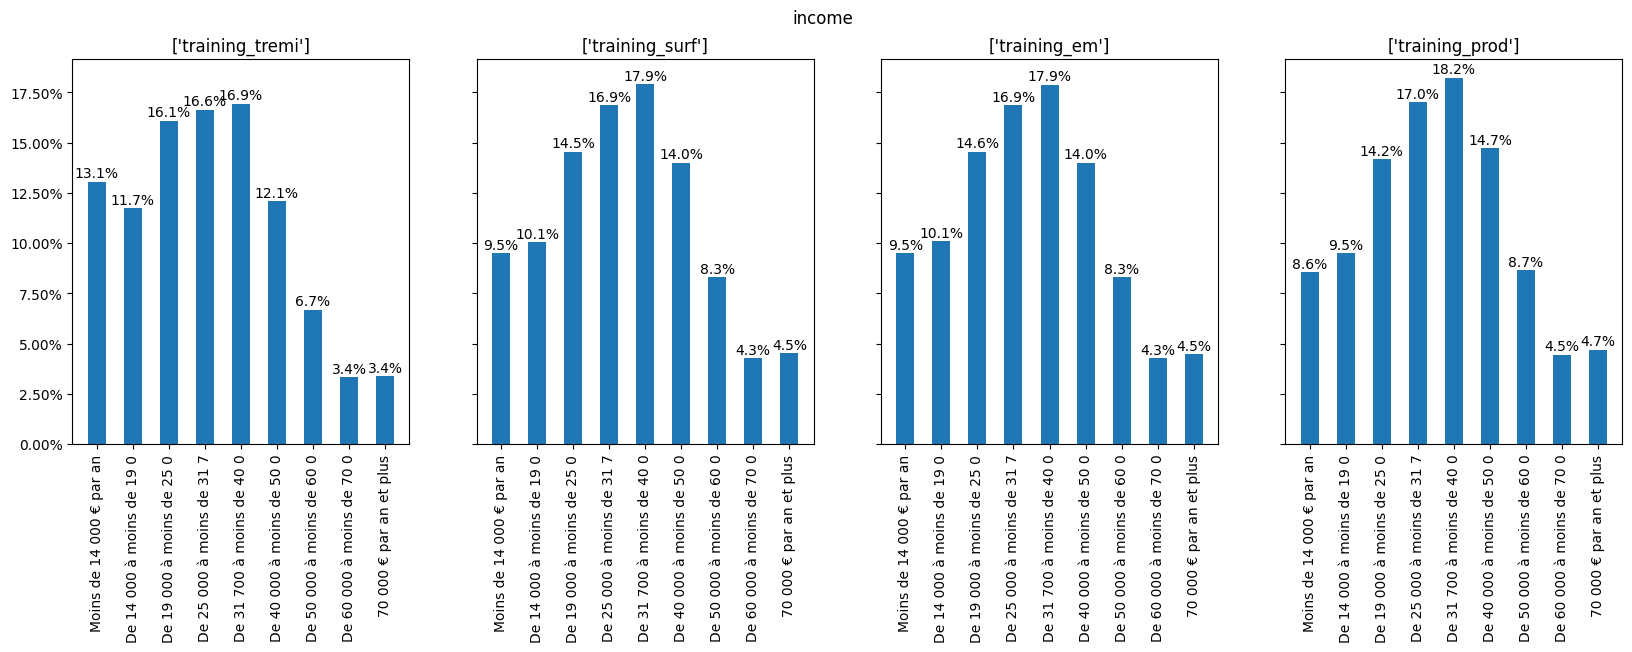

In [74]:
dfs = [training_tremi, training_surf, training_em, training_prod]
compare_repartition(dfs, 'gender')
compare_repartition(dfs, 'type')
compare_repartition(dfs, 'construction_date')
compare_repartition(dfs, 'heating_system')
compare_repartition(dfs, 'occupation')
compare_repartition(dfs, 'nb_persons_home')
compare_repartition(dfs, 'income')

In [75]:
def histo(df, variable, bins = 20):
    plt.title(variable)
    plt.hist(df.select(variable).toPandas(), bins=bins)
    plt.show()

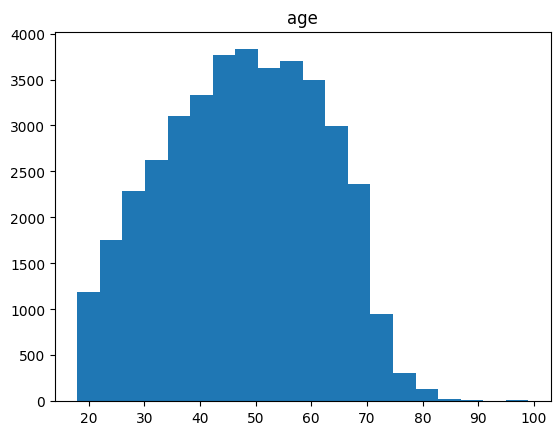

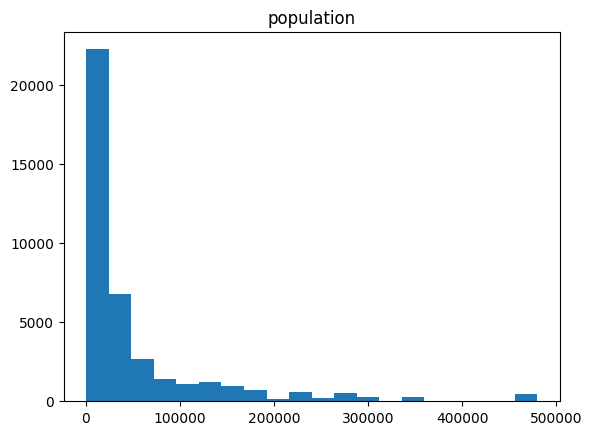

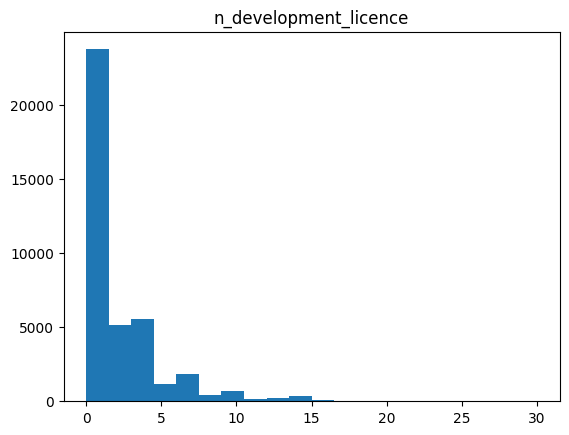

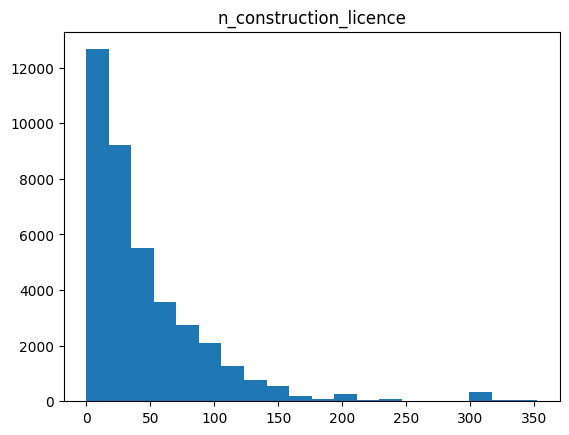

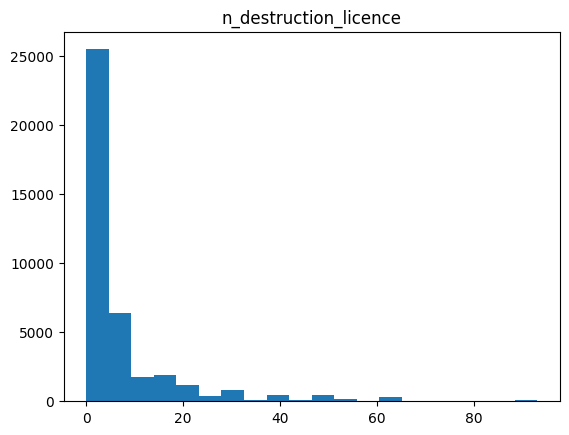

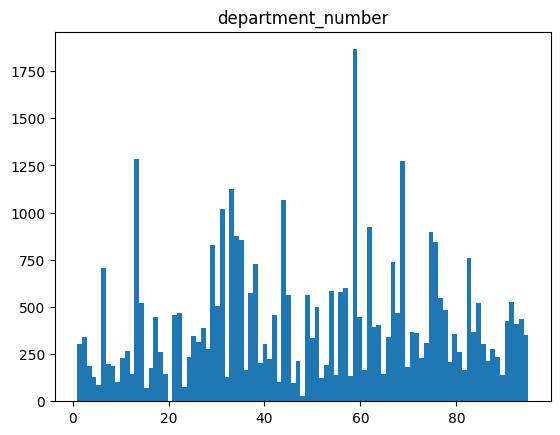

In [76]:
histo(training_tremi, 'age')
histo(training_tremi, 'population')
histo(training_tremi, 'n_development_licence')
histo(training_tremi, 'n_construction_licence')
histo(training_tremi, 'n_destruction_licence')
histo(training_tremi, 'department_number', 95)

# ouput variables

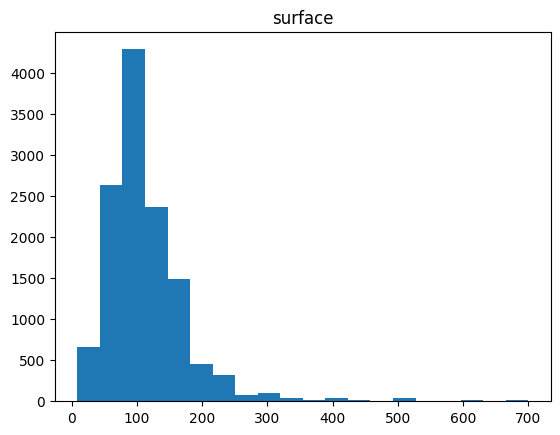

C:\Users\arocheteau\AppData\Local\Temp\ipykernel_3744\2412955291.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%1.2f%%' %i for i in vals])


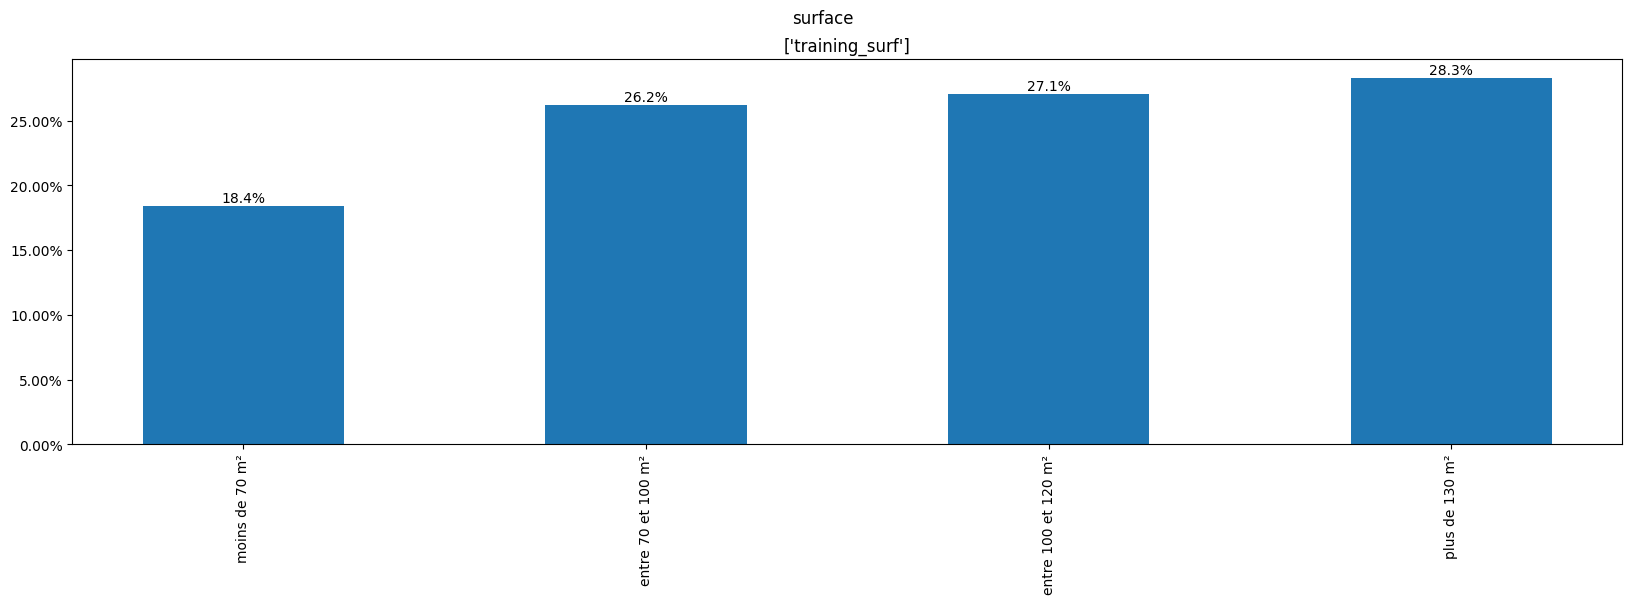

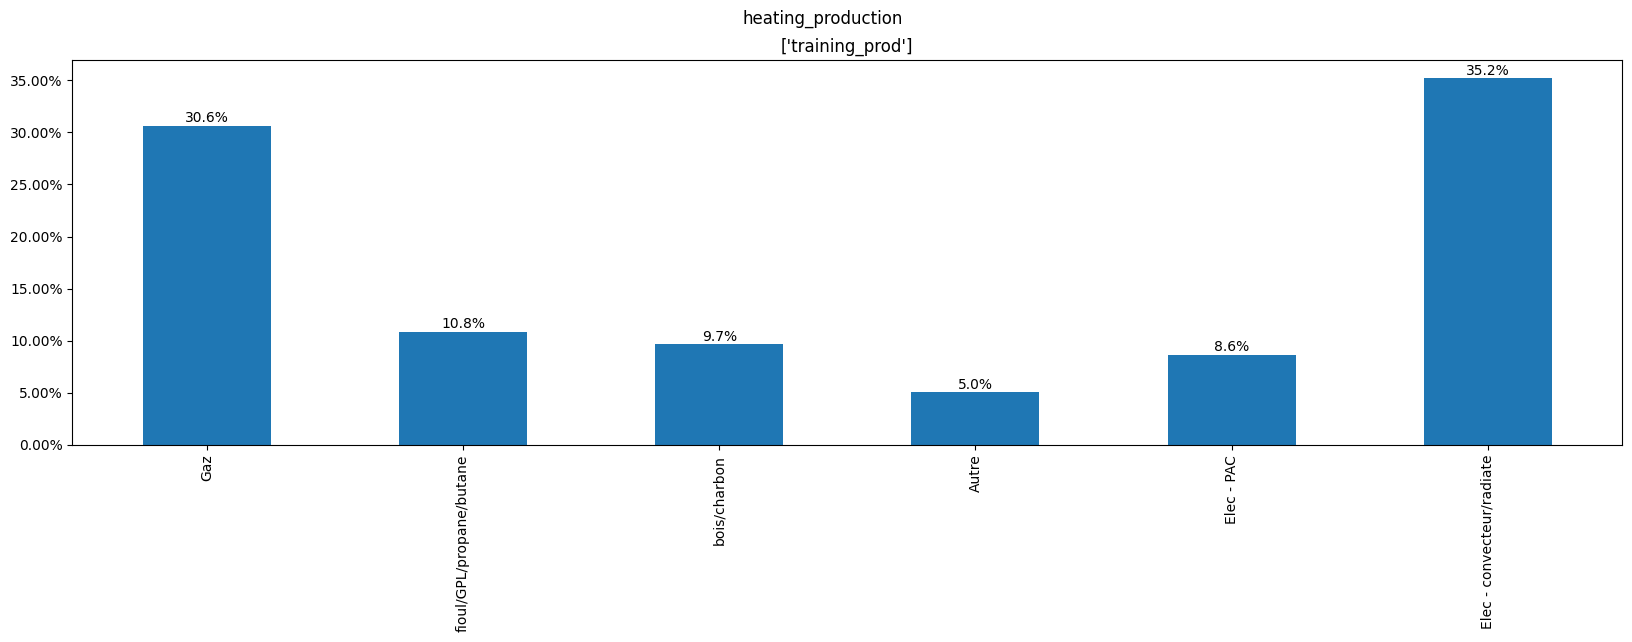

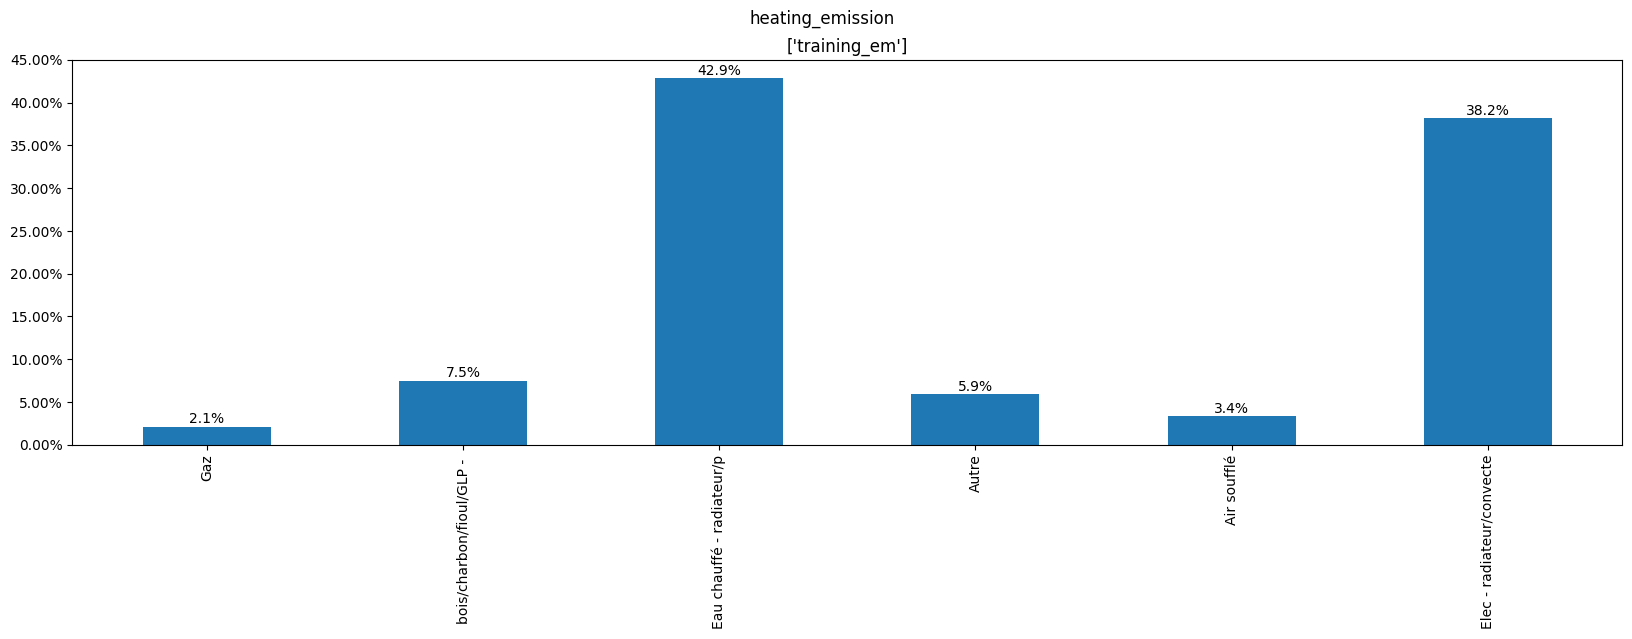

In [77]:
histo(training_surf2, 'surface')
compare_repartition([training_surf], 'surface')
compare_repartition([training_prod], 'heating_production')
compare_repartition([training_em], 'heating_emission')

# ML

In [84]:
import numpy as np
import seaborn as sn

# useful
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix


from copy import deepcopy
from copy import copy

#linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

#random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# XGboost
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

## fonctions

dataset

In [99]:
# prepare data for ML algo
def prepare_dataset(df, col_X_hot, col_X_not_hot, col_y, y_hot, scale):
    labels = ['dummy']
    for variable in (col_X_not_hot):
        labels.append(variable)
    X_not_hot = df.select(col_X_not_hot).toPandas().to_numpy()
    if len(col_X_hot) > 0:
        for variable in col_X_hot:
            labels.extend(get_labels(variable)['meaning'][1:])
        X_hot = df.select(col_X_hot).toPandas()
        X_hot = OneHotEncoder(drop='first', sparse_output=False).fit_transform(X_hot)
        X = np.column_stack((X_not_hot, X_hot))
    else:
        X = X_not_hot.copy()

    y = df.select(col_y).toPandas().to_numpy()
    if y_hot:
        y = OneHotEncoder(drop='first', sparse_output=False).fit_transform(y)
    else:
        y = y.ravel()
    # scale data
    if scale:
        X = StandardScaler().fit_transform(X)
        # y = StandardScaler().fit_transform(y)
    return (X, y, labels)

# coef to correct score
def get_coef(rows, sum):
    return (rows[-1]['count']/sum) - (rows[0]['count']/sum)

# return cuts to make 
def make_cut(first_value, steps, nb_steps):
    cuts = [first_value] + [first_value + steps * (i+1) for i in range(nb_steps)]
    return cuts

# change a variable in a dataframe to categorical with defined cuts
def to_categorical(df, variable, cuts):
    request = 'CASE '
    for i, cut in enumerate(cuts):
        if i == 0:
            request += f"WHEN {variable} < {cut} THEN {i+1}\n"
        else:
            request += f"WHEN {variable} >= {last_cut} AND {variable} < {cut} THEN {i+1}\n"
        last_cut = copy(cut)
    request += f"WHEN surface >= {last_cut} THEN {len(cuts) + 1}\nEND"
    study = df.withColumn('surface', F.expr(request))
    dpe = dataframes['dpe'].withColumn('surface', F.expr(request))

    rows_study = study.groupBy(variable).count().orderBy('count').collect()
    sum_study = study.count()

    rows_dpe = dpe.groupBy(variable).count().orderBy('count').collect()
    sum_dpe = dpe.count()

    coef  = 1 - (np.mean([get_coef(rows_study, sum_study), get_coef(rows_study, sum_study), get_coef(rows_dpe, sum_dpe)]))
    return study, coef


training

In [86]:
# iterate over next hyperparams
def iterate_params(current, max_hyper):
    for i, (max, curr) in enumerate(zip(max_hyper, current)):
        if max == curr:
            current[i] = 0
        else:
            current[i] += 1
            break
    return current

# create dictionary of parameters given the chosen ones
def choose_params(current, hyperparams):
    hyper = {}
    for hyper_nb, (hyper_name, hyper_choices) in zip(current, hyperparams.items()):
        hyper[hyper_name] = hyper_choices[hyper_nb]
    return hyper

# nb of possibility for all hyperparams
def nb_possibility(max_hyper):
    total = 1
    for nb_poss in max_hyper:
        total *= (nb_poss + 1)
    return total
    
def train_hyper(hyperparams, model, X, y, split):
    scores = {}

    # params choice
    current = [0 for _ in range(len(hyperparams))]
    max_hyper = [len(hyperparam) - 1 for hyperparam in hyperparams.values()]
    current_params = choose_params(current, hyperparams)
    all_poss = nb_possibility(max_hyper)

    # training model
    trained_model = model(**current_params)

    # register score
    best_score = cross_val_score(trained_model, X, y, cv=split).mean()
    best_params = current_params.copy()
    best_model = deepcopy(trained_model)
    scores[tuple([param for param in current_params.values()])] = deepcopy(best_score)

    print(all_poss)
    i = 0
    nb_print = (all_poss//4) + 1
    while not all(np.equal(current, max_hyper)):
        # choose params
        current = iterate_params(current, max_hyper)
        current_params = choose_params(current, hyperparams)
        if i % nb_print == 0:
            print(i, current)
        i += 1
        trained_model = model(**current_params)
        current_score = cross_val_score(trained_model, X, y, cv=split).mean()
        scores[tuple([param for param in current_params.values()])] = deepcopy(current_score)
        if current_score > best_score:
            best_score = deepcopy(current_score)
            best_params = deepcopy(current_params)
            best_model = deepcopy(trained_model)
    return (best_model, best_score, best_params, scores)

show_results

In [87]:
def show_hyperparam_opti(scores, hyperparams, ax, model_name):
    x_pos = [i for i in range(len(scores))]
    scores = dict(sorted(scores.items(), key=lambda x:x[1]))

    ax.plot(x_pos, scores.values())
    ax.set_xticks(x_pos, labels=scores.keys(), rotation=90)
    ax.set_title(f'''{model_name}\n{tuple(hyperparams.keys())}''')

def show_result(y_pred, y_true, ax, model_name):
    df = pd.DataFrame(np.column_stack((y_pred, y_true)), columns = ['pred', 'true'])
    df = df.sort_values(by=['true'])
    df.reset_index(inplace = True, drop=True)
    ax.plot(df['true'])
    ax.scatter(df['pred'])
    ax.legend(['pred', 'true'])
    ax.set_ylabel('surface')
    ax.set_xticks([])
    ax.set_title(model_name)

def show_matrix(y_pred, y_true, ax, model_name):
    matrix = confusion_matrix(y_true, y_pred)
    sn.heatmap(matrix/np.sum(matrix), ax=ax, annot=True, fmt='.1%')
    ax.set_title(model_name)


def show_importance(model, labels, ax, model_name):
    y_pos = [i for i in range(len(labels))]
    if isinstance(model, Ridge):
        ax.barh(y_pos, model.coef_.T.ravel(), align = 'center')
    elif isinstance(model, LogisticRegression):
        ax.barh(y_pos, model.coef_.T.mean(axis = 1).ravel(), align = 'center')
    
    elif isinstance(model, RandomForestRegressor) or isinstance(model, RandomForestClassifier) or isinstance(model, GradientBoostingClassifier) or isinstance(model, GradientBoostingRegressor):
        ax.barh(y_pos, model.feature_importances_.T.ravel(), align = 'center')
    else:
        print('pol degree > 1, too many features')
    ax.set_yticks(y_pos, labels = labels)
    ax.set_title(model_name)


In [88]:
# call every functions above
def all_in_one(df, col_X_hots, col_X_not_hots, col_y, y_hot, scale, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4, show=True):

    # store best_models
    best_models = {}

    # prepare to plot
    if show:
        f1, ax_result = plt.subplots(1, len(models), figsize=(15,5), sharey= True)
        f2, ax_hyper = plt.subplots(1, len(models), figsize=(15,5), sharey= True)
        f3, ax_importance = plt.subplots(1, len(models), figsize=(15,20))

    #iterate over models
    for i, (col_X_hot, col_X_not_hot, hyperparams, (model_name, model)) in enumerate(zip(col_X_hots, col_X_not_hots, hyperparams_models, models.items())):
        # prepare data
        X, y, labels = prepare_dataset(df, col_X_hot, col_X_not_hot, col_y, y_hot, scale)
        poly = PolynomialFeatures(degree_poly)
        X_transformed = poly.fit_transform(X)
        cv = ShuffleSplit(n_splits=4, test_size=test_size, random_state=random_state)
        
        # training models
        best_model, best_score, best_params, scores = train_hyper(hyperparams, model, X_transformed, y, cv)
        best_models[model_name] = [deepcopy(best_model), best_score]

        # plot results
        print(best_score, best_params)
        y_pred = cross_val_predict(best_model, X_transformed, y, cv=4)
        if show:
            if len(hyperparams) > 1:
                if len(np.unique(y)) > 10:
                    show_result(y_pred, y, ax_result[i], model_name)
                else:
                    show_matrix(y_pred, y, ax_result[i], model_name)
                show_hyperparam_opti(scores, hyperparams, ax_hyper[i], model_name)
                show_importance(best_model.fit(X_transformed[list(cv.split(X_transformed))[0][0]], y[list(cv.split(y))[0][0]]), labels, ax_importance[i], model_name)
            else:
                if len(np.unique(y)) > 10:
                    show_result(y_pred, y, ax_result, model_name)
                else:
                    show_matrix(y_pred, y, ax_result, model_name)
                show_hyperparam_opti(scores, hyperparams, ax_hyper[i], model_name)
                show_importance(best_model.fit(X_transformed[list(cv.split(X_transformed))[0][0]], y[list(cv.split(y))[0][0]]), labels, ax_importance, model_name)

    return best_models


# make cut Surf

In [101]:
col_X_hot = [[]]
col_y = ['surface']
col_X_not_hot = [[col[0] for col in training_surf2.dtypes if col[0] not in col_X_hot + col_y ]]

hyperparams_models = [
    {
        'n_estimators' : [100],
        # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
        'max_depth' : [10],
        'class_weight' : ['balanced'],
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
        # 'max_features' : ["sqrt", "log2", "auto"]
    }
]
models = {
    'RandomForestClassifier' : RandomForestClassifier
}
cut_params = {
    'first_value' : [40,50,60],
    'steps' : [20,25,30,35,40,45],
    'nb_steps' : [2,3,4]
}

current = [0 for _ in range(len(cut_params))]
max_hyper = [len(cut_param) - 1 for cut_param in cut_params.values()]
current_params = choose_params(current, cut_params)
all_poss = nb_possibility(max_hyper)
print(all_poss)

cuts = make_cut(**current_params)
categorical_surf, coef = to_categorical(training_surf2, 'surface', cuts)
# register score
best_models = all_in_one(categorical_surf, col_X_hot, col_X_not_hot, col_y, False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4, show=False)
max_score = deepcopy(best_models['RandomForestClassifier'][1])
best_split = deepcopy(current_params)
scores = {}
coefs = {}
score_corrected = coef * best_models['RandomForestClassifier'][1]
print(score_corrected)
coefs[tuple([param for param in current_params.values()])] = deepcopy(coef)
scores[tuple([param for param in current_params.values()])] = deepcopy(score_corrected)

i = 0
nb_print = (all_poss//4) + 1
while not all(np.equal(current, max_hyper)):
    # choose params
    current = iterate_params(current, max_hyper)
    current_params = choose_params(current, cut_params)
    if i % nb_print == 0:
        print(i, current)
    i += 1
    cuts = make_cut(**current_params)
    categorical_surf, coef = to_categorical(training_surf2, 'surface', cuts)
    best_models = all_in_one(categorical_surf, col_X_hot, col_X_not_hot, col_y, False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4, show=False)
    score_corrected = coef * best_models['RandomForestClassifier'][1]
    print(score_corrected)
    scores[tuple([param for param in current_params.values()])] = deepcopy(score_corrected)
    coefs[tuple([param for param in current_params.values()])] = deepcopy(coef)
    if score_corrected > max_score:
        max_score = deepcopy(score_corrected)
        best_split = deepcopy(current_params)

54
1
0.7295563072025468 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.3860580888650803
0 [1, 0, 0]
1
0.6651910067648229 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.4097026025748479
1
0.5988360525268603 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.42557949359708347
1
0.682650218861918 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.4015855843815634
1
0.6067449263828093 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.4119169494909795
1
0.5349681655391962 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.4167770292449815
1
0.6287306008754476 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.40946299299353667
1
0.5478511738957421 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.40940230050322746
1
0.5129824910465579 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.4238450638982636
1
0.5798846000795861

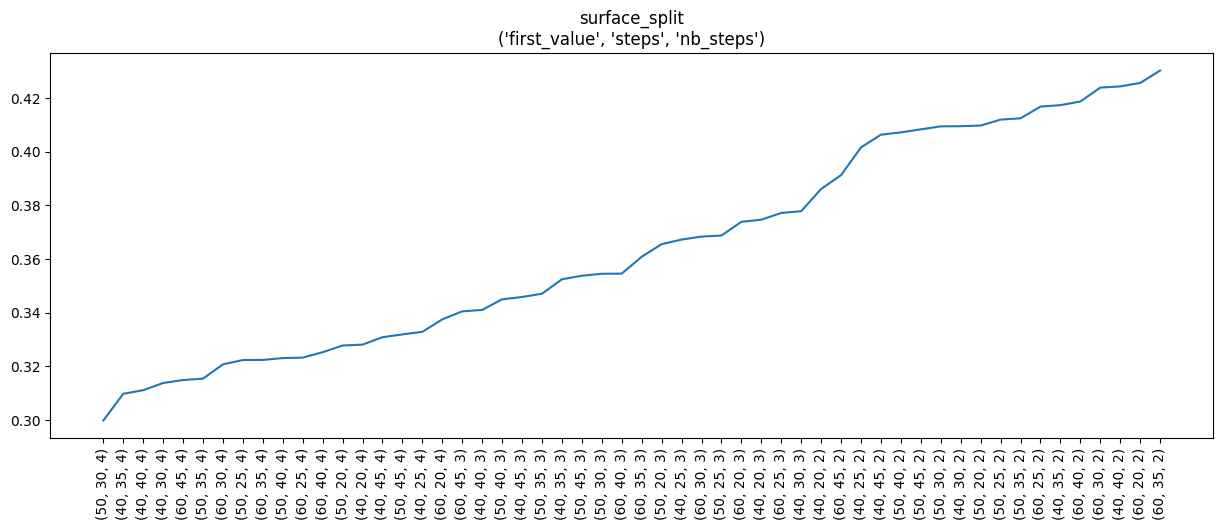

In [102]:
f, ax_hyper = plt.subplots(1, 1, figsize=(15,5), sharey= True)
# show_hyperparam_opti(coefs, cut_params, ax_hyper, 'surface_split')
show_hyperparam_opti(scores, cut_params, ax_hyper, 'surface_split')
plt.show()

In [ ]:
# make the best split
best_params = scores
cuts = make_cut(**current_params)
categorical_surf, coef = to_categorical(training_surf2, 'surface', cuts)
training_surf2 = training_surf2.withColumn('surface')    


## surface

4
0 [0, 1]
2 [0, 3]
0.5052725825706328 {'max_iter': 300, 'C': 0.1}
9
0 [1, 0]


KeyboardInterrupt: 

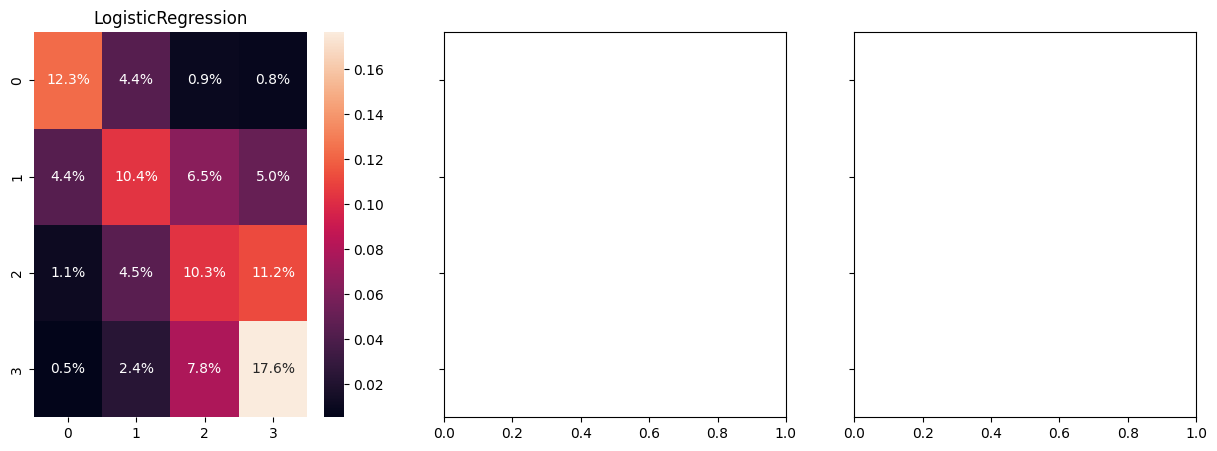

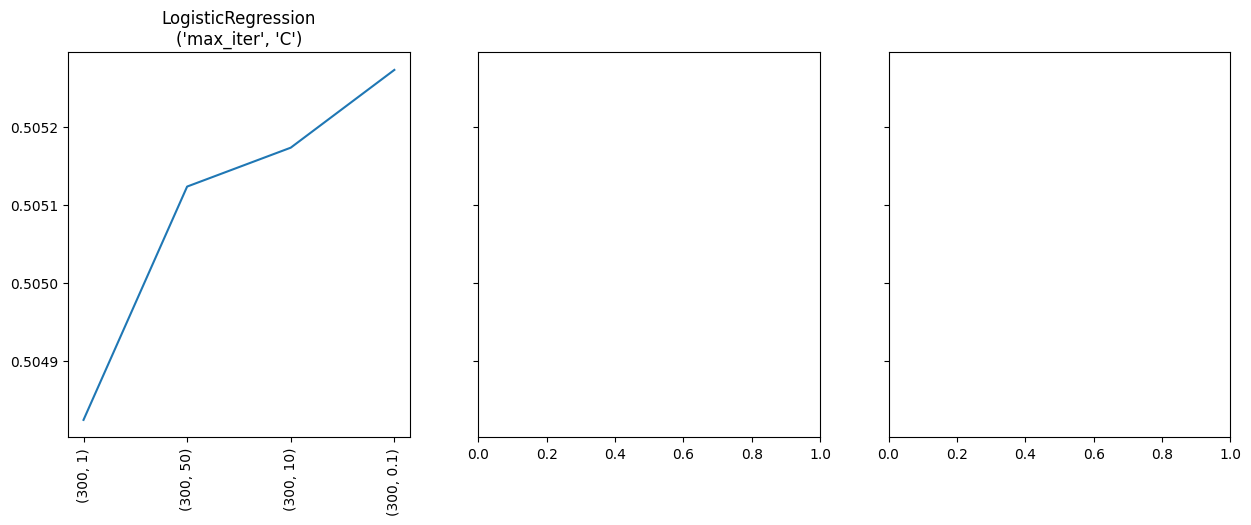

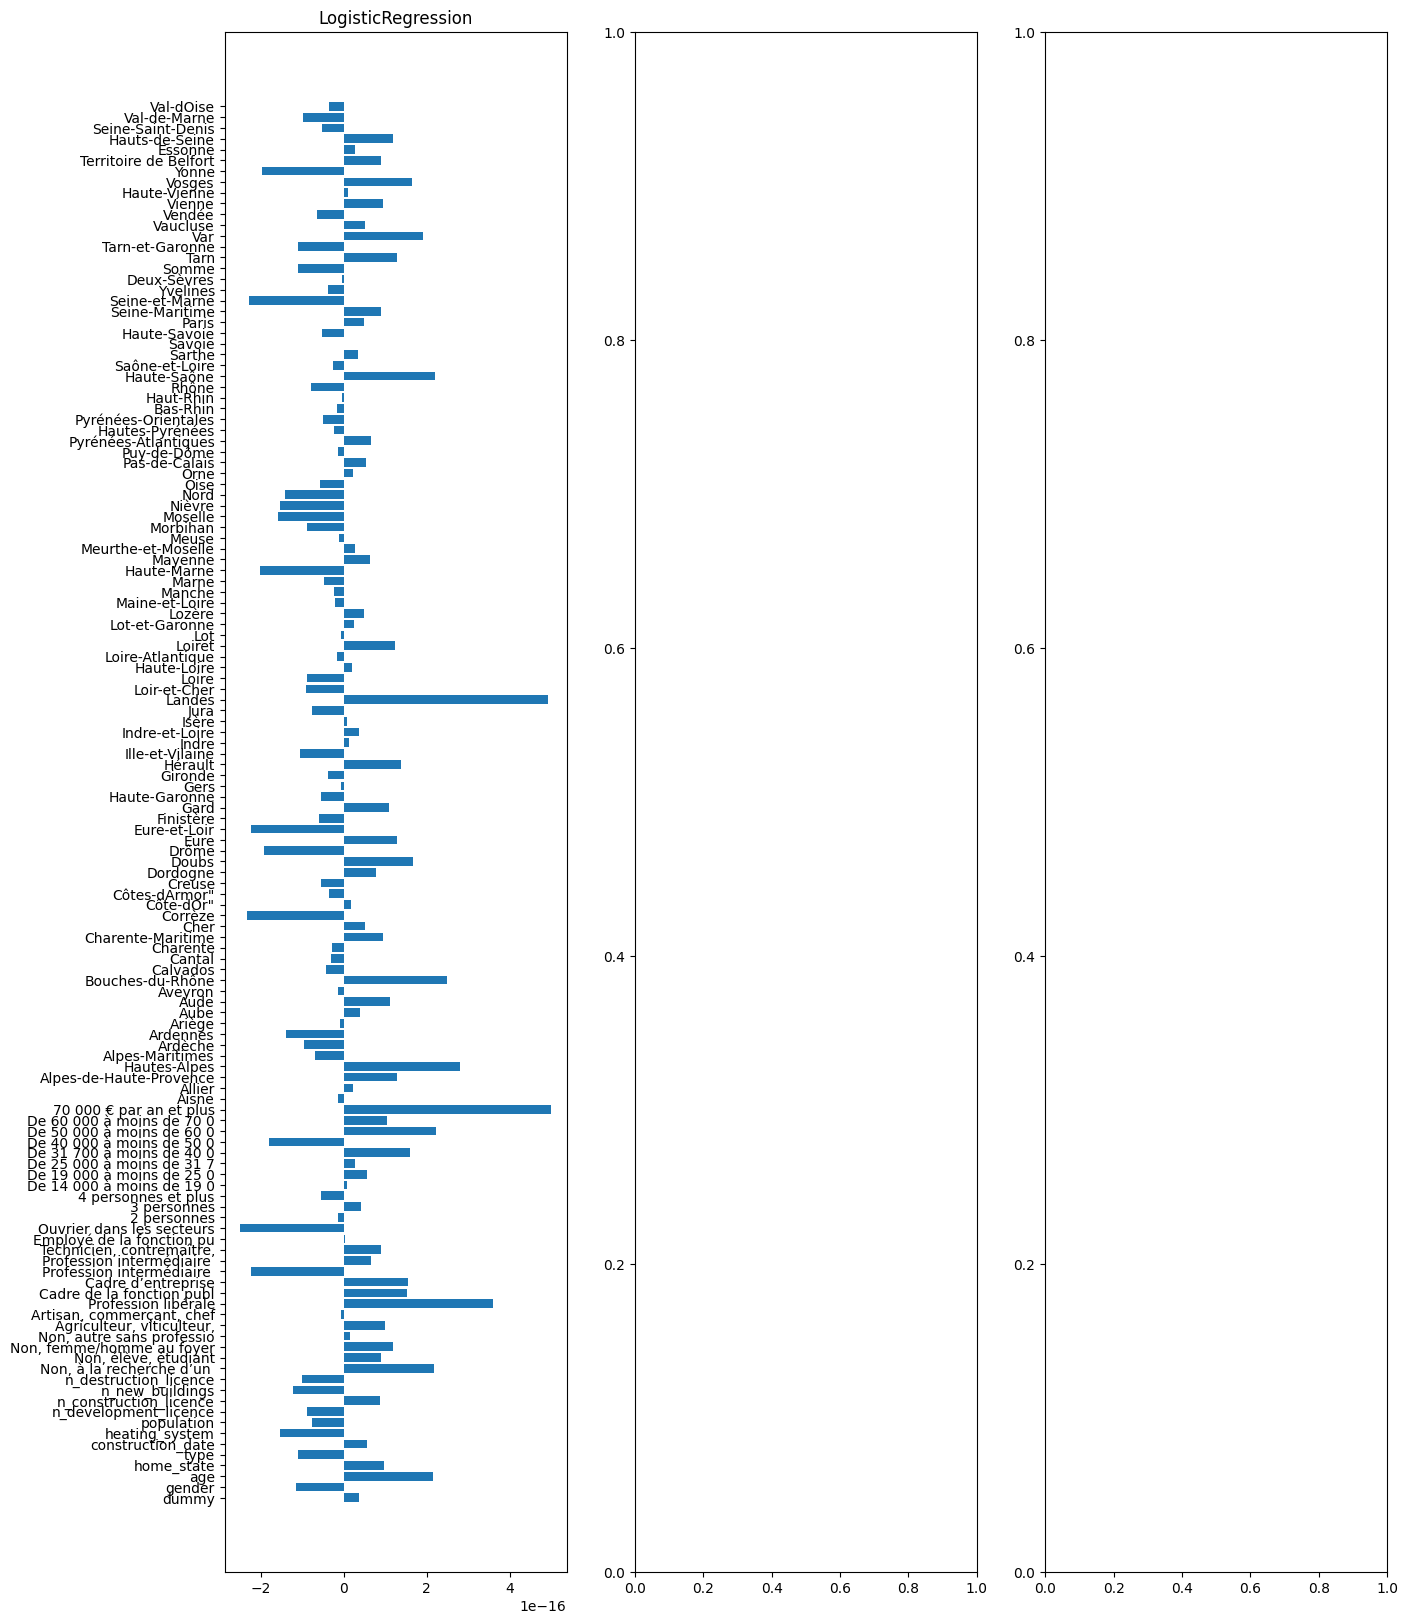

In [16]:
col_X_hot = [['occupation', 'nb_persons_home', 'income', 'department_number'], [], []]
col_y = ['surface']
col_X_not_hot = [
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[0] + col_y ],
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[1] + col_y],
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[2] + col_y]
]

hyperparams_models = [
    {
        'max_iter' : [300],
        'C' : [0.1, 1, 10, 50]
    },
    {
        'n_estimators' : [50, 100, 150],
        # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
        'max_depth' : [2, 10, 20],
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
        # 'max_features' : ["sqrt", "log2", "auto"]
    },
    {
        'learning_rate' : [0.05, 0.1, 0.2],
        'n_estimators' : [50, 100, 150],
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth' : [3, 5, 10],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression' : LogisticRegression,
    'RandomForestClassifier' : RandomForestClassifier,
    'GradientBoostingClassifier' : GradientBoostingClassifier
}
best_models = all_in_one(training_surf, col_X_hot, col_X_not_hot, col_y, False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4)


1
0.5052725825706328 {'max_iter': 300, 'C': 0.1}
LogisticRegression(C=0.1, max_iter=300)
(4, 130)
(130,)
130
[ 3.75269477e-17 -1.15359111e-16  2.15105711e-16  9.71445147e-17
 -1.11022302e-16  5.55111512e-17 -1.52655666e-16 -7.63278329e-17
 -8.76035355e-17  8.67361738e-17 -1.21430643e-16 -1.01481323e-16
  2.16840434e-16  9.02056208e-17  1.19695920e-16  1.38777878e-17
  1.00613962e-16 -6.93889390e-18  3.59087760e-16  1.52655666e-16
  1.55257751e-16 -2.23779328e-16  6.59194921e-17  9.02056208e-17
  3.46944695e-18 -2.49800181e-16 -1.38777878e-17  4.16333634e-17
 -5.55111512e-17  8.40256684e-18  5.51858906e-17  2.77555756e-17
  1.59594560e-16 -1.80411242e-16  2.22044605e-16  1.04083409e-16
  4.99600361e-16 -1.34441069e-17  2.16840434e-17  1.28803218e-16
  2.81025203e-16 -7.02563008e-17 -9.48676901e-17 -1.40404181e-16
 -9.54097912e-18  3.81639165e-17  1.11455983e-16 -1.38777878e-17
  2.49800181e-16 -4.16333634e-17 -3.12250226e-17 -2.77555756e-17
  9.36750677e-17  5.11743425e-17 -2.32452946e-

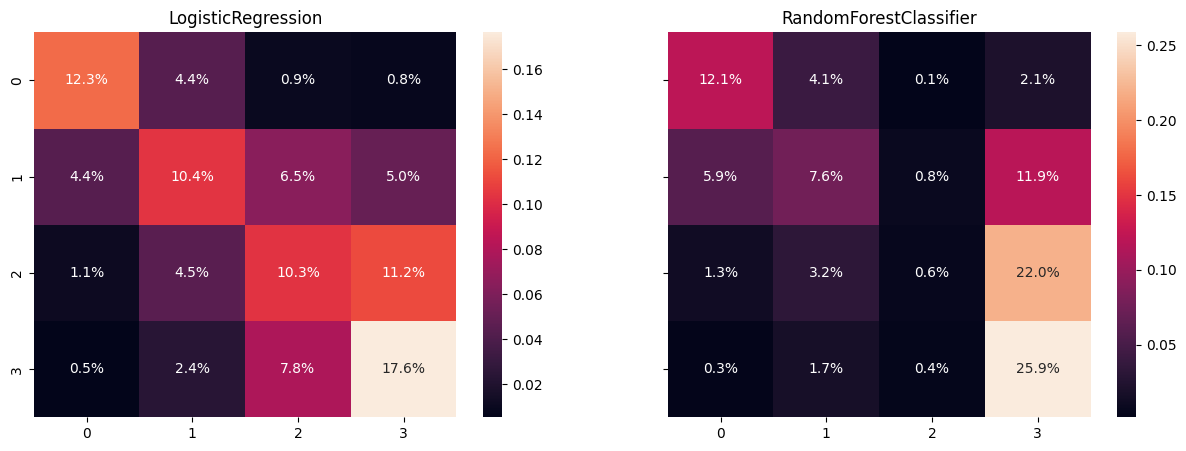

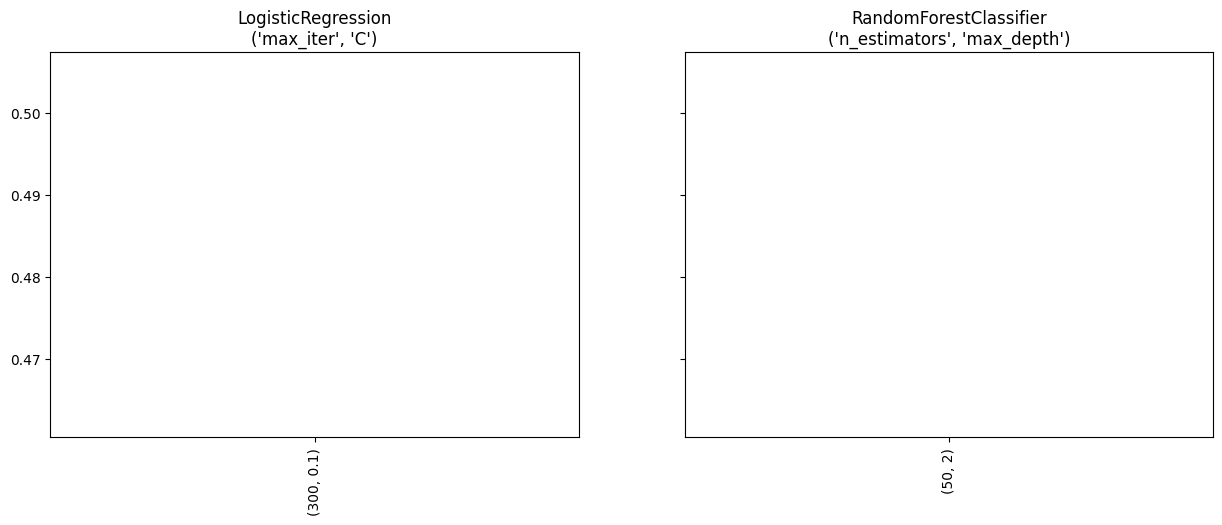

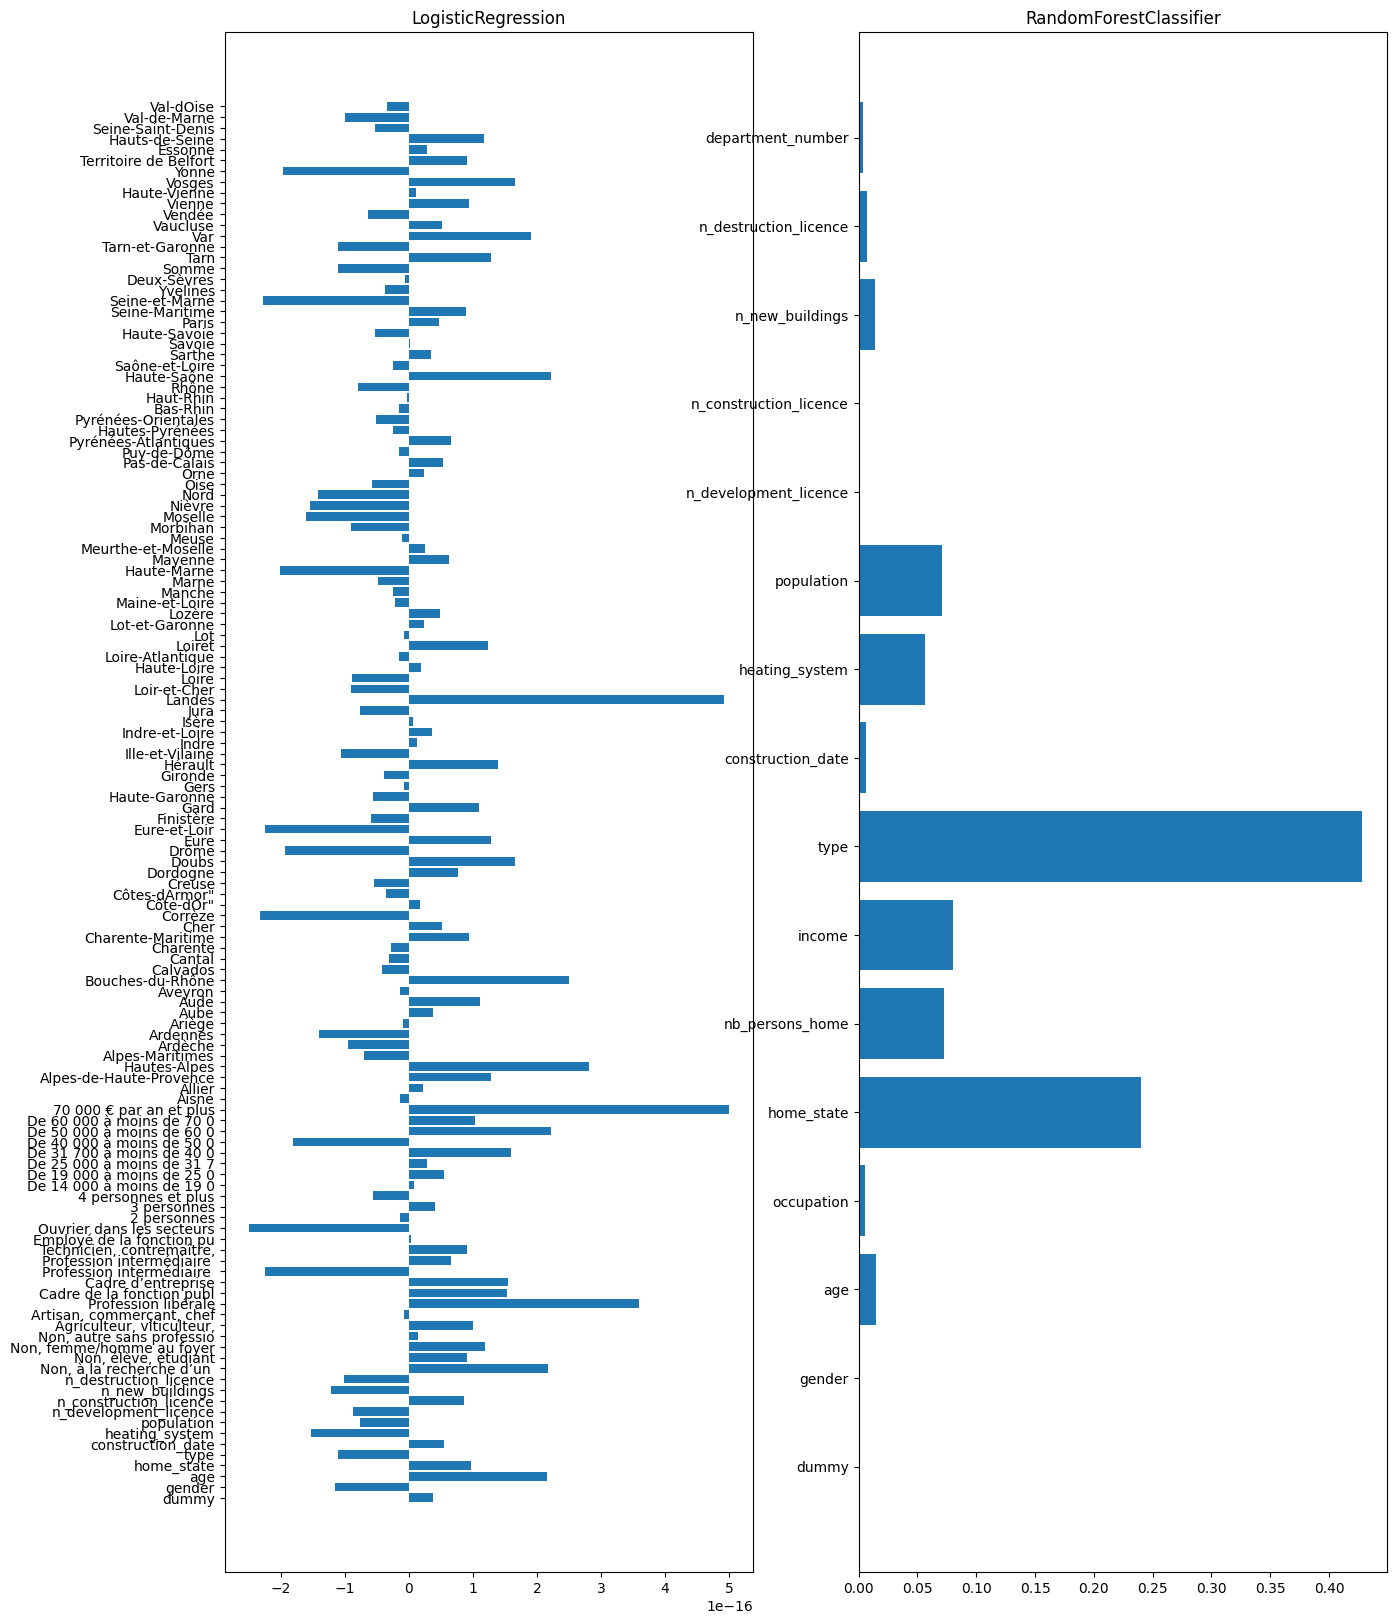

In [ ]:
col_X_hot = [['occupation', 'nb_persons_home', 'income', 'department_number'], []]
col_y = ['surface']
col_X_not_hot = [
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[0] + col_y ],
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[1] + col_y]
]

hyperparams_models = [
    {
        'max_iter' : [300],
        'C' : [0.1]
    },
    {
        'n_estimators' : [50],
        # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
        'max_depth' : [2],
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
        # 'max_features' : ["sqrt", "log2", "auto"]
    }
]
models = {
    'LogisticRegression' : LogisticRegression,
    'RandomForestClassifier' : RandomForestClassifier
}
best_models = all_in_one(training_surf, col_X_hot, col_X_not_hot, col_y, False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4)
